In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import check_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops.distributions import bijector

from tensorflow.contrib.distributions import Normal
from tensorflow.python.ops import nn
from pymisca.transformed_distribution import TransformedDistribution
# array_ops.gather_nd?

/home/shouldsee/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/

import numpy as np
import pymisca.util as pyutil
import pymisca.vis_util as pyvis
%matplotlib inline 

D = 2


TRUE_MU = 0.0
TRUE_SIGMA = 2.0
SAMPLE_SIZE = (5000,D)

np.random.seed(0)
x_obs = np.random.normal(loc=TRUE_MU, scale=TRUE_SIGMA, size=SAMPLE_SIZE)
rsq = np.square(x_obs).sum(axis=-1)

# keep = rsq > np.mean(rsq)
# x_obs = x_obs[keep]


C = pyutil.random_covmat()
# x_obs = 
x_obs = x_obs.dot(C)
# x_obs.T[0] = x_obs.T[0]*

# x_obs = np.square(x_obs)


is in ipython: 1
is in ipython: 1
[WARN] pymisca.vis_util cannot find network


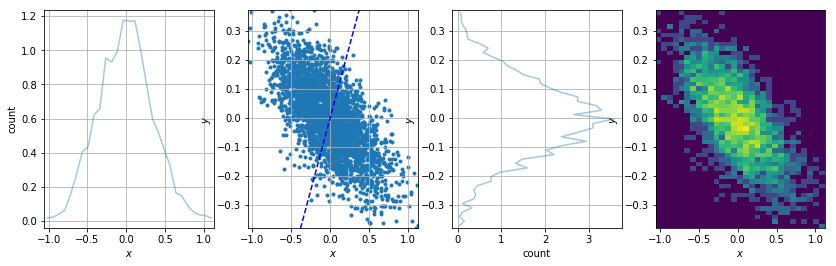

In [3]:
pyvis.qc_2var(x_obs.T[0],x_obs.T[1])

In [4]:
import pymisca.tensorflow_extra as pytf
reload(pytf)




from tensorflow.python.ops import nn
import tensorflow as tf

# data
x = tf.placeholder(dtype=tf.float32)

INIT_MU_PARAMS = {'loc': 0.0, 'scale': 0.1}
INIT_PHI_PARAMS = {'loc': 1.0, 'scale': 0.1}
RANDOM_SEED = 0

# params
np.random.seed(RANDOM_SEED)
mu = 1. + nn.softplus(tf.Variable(initial_value=np.random.normal(**INIT_MU_PARAMS),
                 dtype=tf.float32)
                )
phi =nn.softplus( tf.Variable(initial_value=np.random.normal(**INIT_PHI_PARAMS),
                  dtype=tf.float32)
                )
sigma =nn.softplus( tf.Variable(initial_value=np.random.normal(size=(D,),
                                                               **INIT_PHI_PARAMS),
                  dtype=tf.float32)
                )

# sigma = tf.square(phi)

# loss

def makeEMD( (mu,phi,sigma) ):
    dist_rsq = mdl = tf.contrib.distributions.Gamma(concentration=mu,rate=phi)

    #### Use a bijector to calculate P(x) from P(r^2)
    dist_xyz = mdl = pytf.AsRadial(distribution=dist_rsq,
                                   D=D)
    
    ### Allow an affine transformation y = M x + x_0
    dist_aff = mdl = pytf.AffineTransformDiag(distribution=dist_xyz,
                                        scale_diag=sigma,)
    
    mdl = dist_aff
    
    # gaussian_dist = tf.contrib.distributions.Normal(loc=mu, scale=sigma)
    # mdl  = dist_rsq
    return mdl


fitted_vars = [mu,phi,sigma]
emission = makeEMD(fitted_vars)


# assert 0

[WARN]unable to import edward.models
[WARN]unable to import edward.models
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


In [5]:
fitted_vars = [mu,phi,sigma]
emission = makeEMD(fitted_vars)
log_prob = emission.log_prob(value=x)
neg_log_likelihood = -1.0 * tf.reduce_sum(log_prob)


# gradient
free_vars = [sigma]
grad = tf.gradients(neg_log_likelihood, free_vars)

In [6]:
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/
reload(pytf)
LEARNING_RATE = 0.1
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
sess,last_vars, hist_loss, opt = pytf.op_minimise(
    neg_log_likelihood,
    free_vars,
#     fitted_vars,
    optimizer,
    feed_dict = {x: x_obs}
)

[WARN]unable to import edward.models
Iter 0 48666692.0
Iter 100 -45729130.0
Iter 200 -59177356.0
Iter 300 -66847620.0
Iter 400 -72307310.0
Iter 500 -76579580.0
Iter 600 -80106600.0
Iter 700 -83121610.0
Iter 800 -85763160.0
Iter 900 -88119970.0
Iter 1000 -90251770.0
Iter 1100 -92203630.0
Iter 1200 -94005360.0
Iter 1300 -95683580.0
Iter 1400 -97254890.0
Iter 1500 -98734900.0
Iter 1600 -100135080.0
Iter 1700 -101466550.0
Iter 1800 -102736620.0
Iter 1900 -103953770.0
Iter 2000 -105120376.0
Iter 2100 -106244990.0
Iter 2200 -107329704.0
Iter 2300 -108378744.0
Iter 2400 -109394710.0
Iter 2500 -110380300.0
Iter 2600 -111339990.0
Iter 2700 -112274650.0
Iter 2800 -113184980.0
Iter 2900 -114074700.0
Iter 3000 -114943900.0
Iter 3100 -115794910.0
Iter 3200 -116628650.0
Iter 3300 -117445090.0
Iter 3400 -118248610.0
Iter 3500 -119035270.0
Iter 3600 -119810024.0
Iter 3700 -120571320.0
Iter 3800 -121321310.0
Iter 3900 -122060264.0


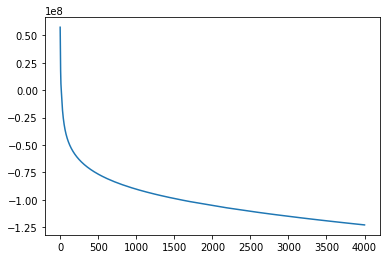

In [7]:
import pymisca.vis_util as pyvis
%matplotlib inline 

plt = pyvis.plt
plt.plot(hist_loss)

In [8]:
print (last_vars)

[array([36.02152 , 29.471025], dtype=float32)]


In [9]:
with sess.as_default():
    print ([x.eval() for x in emission.distribution._graph_parents])

[1.0000279, 138.18327]


Instructions for updating:
dim is deprecated, use axis instead


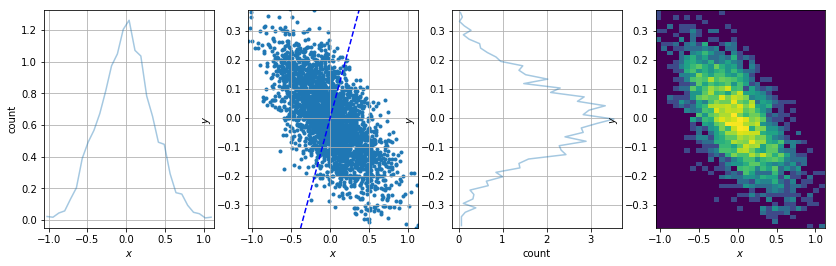

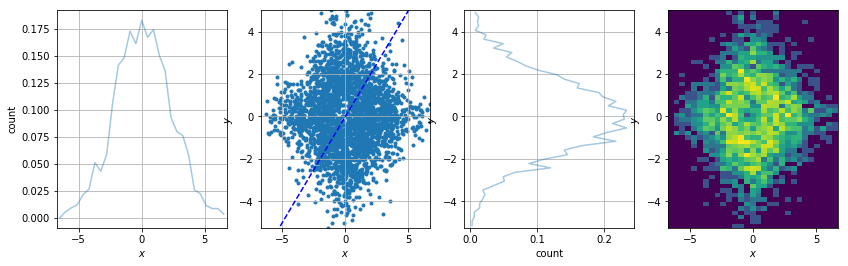

In [11]:
with sess.as_default():
# sess = tf.InteractiveSession()
# if 1:
#     EMD = makeEMD(last_vars)
    X = x_obs
    Y = emission.sample(len(X)).eval()
#     Y = 
#     Y = EMD.sample(len(X)).eval()

    pyvis.qc_2var(X.T[0],X.T[1])
    pyvis.qc_2var(Y.T[0],Y.T[1])